<a href="https://colab.research.google.com/github/santoshrsarangi/tensorflow/blob/main/computer-vision/5_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz

--2022-09-19 12:26:18--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2022-09-19 12:26:19--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2022-09-19 12:26:19--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7

In [2]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

--2022-09-19 12:26:46--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/octet-stream]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  15.6MB/s    in 1.2s    

2022-09-19 12:26:48 (15.6 MB/s) - ‘annotations.tar.gz’ saved [19173078/19173078]



In [3]:
ls -l

total 792092
-rw-r--r-- 1 root root  19173078 Jul 29 08:44 annotations.tar.gz
-rw-r--r-- 1 root root 791918971 Jul 29 08:44 images.tar.gz
drwxr-xr-x 1 root root      4096 Sep 14 13:44 sample_data/


In [4]:
!tar -xf annotations.tar.gz
!tar -xf images.tar.gz

In [5]:
ls -lrt

total 792384
drwxr-xr-x 2 1001  1001    294912 Jun 18  2012 images/
drwxr-xr-x 4  501 staff      4096 Jun 30  2012 annotations/
-rw-r--r-- 1 root root   19173078 Jul 29 08:44 annotations.tar.gz
-rw-r--r-- 1 root root  791918971 Jul 29 08:44 images.tar.gz
drwxr-xr-x 1 root root       4096 Sep 14 13:44 sample_data/


In [6]:
import os, pathlib, shutil

In [7]:
src_dir_images = pathlib.Path("images")

In [8]:
image_files = []

for file in sorted(os.listdir(src_dir_images)):

  if file.endswith(".jpg"):
    image_files.append(file)

In [9]:
src_dir_annotations = pathlib.Path("annotations/trimaps")

In [10]:
annotation_files = []

for file in sorted(os.listdir(src_dir_annotations)):

  if file.endswith(".png") and not file.startswith("."):
    annotation_files.append(file)

In [11]:
import matplotlib.pyplot as plt

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array

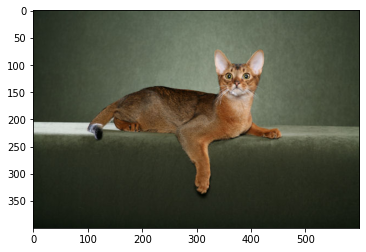

In [13]:
plt.imshow(load_img(src_dir_images / image_files[0]))
plt.show()

In [14]:
image_files[0]

'Abyssinian_1.jpg'

In [15]:
len(annotation_files)

7390

In [16]:
annotation_files[0]

'Abyssinian_1.png'

In [17]:
x = src_dir_annotations / annotation_files[0]

In [18]:
y = img_to_array(load_img(x)).astype("uint8")

In [19]:
y.shape

(400, 600, 3)

In [20]:
y = (y - 1)*127

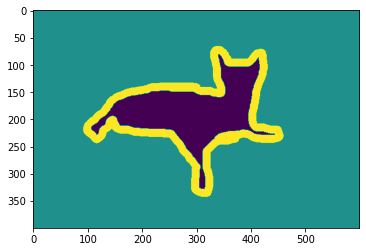

In [21]:
plt.imshow(y[:, :, 2])
plt.show()

In [22]:
import numpy as np
import random

In [23]:
img_size = (200, 200)

In [24]:
num_images = len (image_files)

In [25]:
random.Random(1337).shuffle(image_files)
random.Random(1337).shuffle(annotation_files)

In [26]:
def img_array(path):
  return img_to_array(load_img(path, target_size = img_size))

In [27]:
def annotation_array(path):
  return img_to_array(load_img(path, target_size=img_size, color_mode='grayscale')).astype("uint8") - 1

In [28]:
input_images = np.zeros((num_images,) + img_size + (3,), dtype="float32")

In [29]:
input_images.shape

(7390, 200, 200, 3)

In [30]:
targets = np.zeros((num_images, ) + img_size + (1,), dtype="uint8")

In [31]:
targets.shape

(7390, 200, 200, 1)

In [32]:
for i in range(num_images):
  input_images[i] = img_array(src_dir_images / image_files[i])
  targets[i] = annotation_array(src_dir_annotations / annotation_files[i])

In [33]:
val_size = 1000

In [34]:
training_images = input_images[: -val_size]
training_labels = targets[:-val_size]

validation_images = input_images[-val_size:]
validation_labels = targets[-val_size:]

In [35]:
def get_model(img_size, num_classes):

  inputs = keras.Input(shape=img_size + (3, ))

  x = layers.Rescaling(1./255)(inputs)

  x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu", padding='same')(x)
  x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
  x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu", padding='same')(x)
  x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
  x = layers.Conv2D(filters=256, kernel_size=3, strides=2, activation="relu", padding='same')(x)
  x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same')(x)

  x = layers.Conv2DTranspose(filters=256, kernel_size=3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(filters=256, kernel_size=3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(filters=128, kernel_size=3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(filters=128, kernel_size=3, activation="relu", padding="same", strides=2)(x)
  x = layers.Conv2DTranspose(filters=64, kernel_size=3, activation="relu", padding="same")(x)
  x = layers.Conv2DTranspose(filters=64, kernel_size=3, activation="relu", padding="same", strides=2)(x)

  outputs = layers.Conv2D(filters=num_classes, kernel_size=3, activation="softmax", padding="same")(x)

  model = keras.Model(inputs, outputs)

  return model


In [36]:
model = get_model(img_size, 3)

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [38]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [39]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="image-segmentation.keras", monitor="val_loss", save_best_only=True),
    keras.callbacks.TensorBoard(log_dir="seg-logs")
]

In [40]:
training_images.shape

(6390, 200, 200, 3)

In [41]:
validation_images.shape

(1000, 200, 200, 3)

In [42]:
training_labels.shape

(6390, 200, 200, 1)

In [43]:
validation_labels.shape

(1000, 200, 200, 1)

In [51]:
history = model.fit(training_images,
                    training_labels,
                    epochs=20,
                    callbacks=callbacks,
                    validation_data=(validation_images, validation_labels),
                    #validation_split=0.2,
                    batch_size=32)

Epoch 1/20
200/200 [==============================] - 80s 316ms/step - loss: 10.1182 - accuracy: 0.5801 - val_loss: 0.8323 - val_accuracy: 0.6170
Epoch 2/20
200/200 [==============================] - 60s 301ms/step - loss: 0.8366 - accuracy: 0.6510 - val_loss: 0.8584 - val_accuracy: 0.6558
Epoch 3/20
200/200 [==============================] - 61s 306ms/step - loss: 0.7356 - accuracy: 0.6915 - val_loss: 0.6236 - val_accuracy: 0.7467
Epoch 4/20
200/200 [==============================] - 63s 317ms/step - loss: 0.6636 - accuracy: 0.7336 - val_loss: 0.7870 - val_accuracy: 0.6899
Epoch 5/20
200/200 [==============================] - 64s 318ms/step - loss: 0.6017 - accuracy: 0.7577 - val_loss: 0.5565 - val_accuracy: 0.7775
Epoch 6/20
200/200 [==============================] - 62s 312ms/step - loss: 0.5613 - accuracy: 0.7772 - val_loss: 0.5212 - val_accuracy: 0.7928
Epoch 7/20
200/200 [==============================] - 62s 312ms/step - loss: 0.5259 - accuracy: 0.7925 - val_loss: 0.6449 - val_a

In [52]:
model = keras.models.load_model("image-segmentation.keras")

In [55]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [56]:
from tensorflow.keras.utils import array_to_img

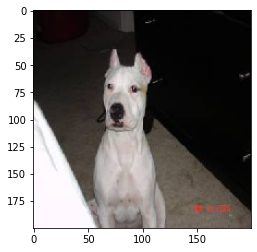

In [57]:
test_image = validation_images[4]

plt.imshow(array_to_img(test_image))

In [61]:
y = np.expand_dims(test_image, 0)

In [62]:
y.shape

(1, 200, 200, 3)

In [65]:
test_image.shape

(200, 200, 3)

In [66]:
mask = model.predict(y)

In [67]:
mask.shape

(1, 200, 200, 3)

In [59]:
def display_mask(pred):
  mask = np.argmax(pred, axis=-1)
  mask *= 127
  plt.axis("off")
  plt.imshow(mask)

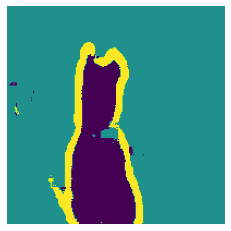

In [68]:
display_mask(mask[0])